## Supervised Learning Methods & Models 

In this section, I will be using various supervised learning models to predict what the counts of Lymes disease will be in each region in the year 2050 under the RCP 8.5 Climate Scenario. I will compare the accuracy of the trained models to determine the optimal model, and perform my final prediction with that model. 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
df = pd.read_csv('../data/clean_data/state_data.csv')

In [3]:
df.columns

Index(['Year', 'Precipitation_avg', 'region', 'Min_temp_avg', 'Avg_temp',
       'State', 'Lyme_cases', 'Total_Land_Area', 'Tree_Cover_Loss',
       'species_richness', 'state_park_land_coverage', 'state_park_rank'],
      dtype='object')

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor, KernelReg
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

def prepare_training_data(df):
    # Create dummy variables for region
    region_dummies = pd.get_dummies(df['region'], prefix='region')
    
    # Select features for prediction
    features = ['Precipitation_avg', 'Min_temp_avg', 'Avg_temp', 
               'Total_Land_Area',
               'state_park_rank', 'state_park_land_coverage']
    
    # Handle missing values with median imputation
    imputer = SimpleImputer(strategy='median')
    
    # Impute numerical features
    X_imputed = pd.DataFrame(
        imputer.fit_transform(df[features]),
        columns=features,
        index=df.index
    )
    
    # Add region dummy columns
    X = pd.concat([X_imputed, region_dummies], axis=1)
    y = df['Lyme_cases']
    
    print("Shape of X after preparation:", X.shape)
    print("Number of missing values in X:", X.isna().sum().sum())
    
    return X, y, imputer

def prepare_future_data(future_df, feature_columns, imputer):
    # Create a DataFrame to store the processed future data
    future_data = pd.DataFrame()
    
    # Process each region's data
    for region in future_df['region'].unique():
        region_data = future_df[future_df['region'] == region]
        
        # Create a row for this region
        row_data = {
            'Precipitation_avg': region_data[region_data['Indicator'] == 'Precipitation_avg']['value'].iloc[0],
            'Min_temp_avg': region_data[region_data['Indicator'] == 'Min_temp']['value'].iloc[0],
            'Avg_temp': region_data[region_data['Indicator'] == 'Avg_temp']['value'].iloc[0],
            'Total_Land_Area': region_data['Total_Land_Area'].iloc[0],
            'state_park_land_coverage': region_data['state_park_land_coverage'].iloc[0],
            'state_park_rank': region_data['state_park_rank'].iloc[0]
        }
        
        # Add region dummy variables
        for reg in ['central', 'eastern', 'southern', 'western']:
            row_data[f'region_{reg}'] = 1 if region == reg else 0
            
        future_data = pd.concat([future_data, pd.DataFrame([row_data])], ignore_index=True)
    
    # Ensure columns match training data
    future_data = future_data[feature_columns]
    
    # Impute missing values using the same imputer from training
    numeric_cols = ['Precipitation_avg', 'Min_temp_avg', 'Avg_temp', 
               'Total_Land_Area',
               'state_park_rank', 'state_park_land_coverage']
    future_data[numeric_cols] = imputer.transform(future_data[numeric_cols])
    
    return future_data

def train_and_evaluate_expanded_models(X, y):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Initialize expanded set of models
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge': Ridge(alpha=1.0),
        'Lasso': Lasso(alpha=1.0),
        'Elastic Net': ElasticNet(alpha=1.0, l1_ratio=0.5),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
        'AdaBoost': AdaBoostRegressor(n_estimators=100, random_state=42),
        'KNN': KNeighborsRegressor(n_neighbors=5),
        'SVR (RBF)': SVR(kernel='rbf'),
        'Kernel Ridge': KernelRidge(kernel='rbf', alpha=1.0)
    }
    
    # Train and evaluate models
    results = {}
    trained_models = {}
    
    for name, model in models.items():
        try:
            # Train model
            model.fit(X_train_scaled, y_train)
            
            # Make predictions
            y_pred = model.predict(X_test_scaled)
            
            # Calculate metrics
            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)
            r2 = r2_score(y_test, y_pred)
            
            # Perform cross-validation
            cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
            
            results[name] = {
                'RMSE': rmse,
                'R2': r2,
                'CV_mean': cv_scores.mean(),
                'CV_std': cv_scores.std()
            }
            trained_models[name] = model
            
        except Exception as e:
            print(f"Error training {name}: {str(e)}")
    
    return results, trained_models, scaler

def plot_expanded_model_comparison(results):
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Prepare data for plotting
    models = list(results.keys())
    rmse_scores = [results[model]['RMSE'] for model in models]
    r2_scores = [results[model]['R2'] for model in models]
    
    # Plot RMSE comparison
    sns.barplot(x=models, y=rmse_scores, ax=ax1)
    ax1.set_title('RMSE Comparison')
    ax1.set_ylabel('RMSE')
    ax1.tick_params(axis='x', rotation=45)
    
    # Plot R² comparison
    sns.barplot(x=models, y=r2_scores, ax=ax2)
    ax2.set_title('R² Score Comparison')
    ax2.set_ylabel('R² Score')
    ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    return fig

def plot_cross_validation_results(results):
    fig, ax = plt.subplots(figsize=(12, 6))
    
    models = list(results.keys())
    cv_means = [results[model]['CV_mean'] for model in models]
    cv_stds = [results[model]['CV_std'] for model in models]
    
    # Plot CV scores with error bars
    ax.errorbar(models, cv_means, yerr=cv_stds, fmt='o', capsize=5)
    ax.set_title('Cross-Validation Scores by Model')
    ax.set_ylabel('CV Score')
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    return fig

# Main execution
if __name__ == "__main__":
    # Load and prepare data as before
    hist_df = pd.read_csv('../data/clean_data/data.csv')
    future_df = pd.read_csv('../data/clean_data/2050inputs.csv')
    
    X, y, imputer = prepare_training_data(hist_df)
    
    # Train and evaluate expanded set of models
    results, trained_models, scaler = train_and_evaluate_expanded_models(X, y)
    
    # Print detailed results
    print("\nModel Performance Metrics:")
    for model_name, metrics in results.items():
        print(f"\n{model_name}:")
        for metric_name, value in metrics.items():
            print(f"{metric_name}: {value:.4f}")
    
    # Plot comparisons
    comparison_fig = plot_expanded_model_comparison(results)
    cv_fig = plot_cross_validation_results(results)
    
    # Prepare and predict with 2050 data
    future_X = prepare_future_data(future_df, X.columns, imputer)
    future_X_scaled = scaler.transform(future_X)
    
    # Make predictions for 2050
    print("\nPredicted Lyme Disease Cases for 2050 by Region:")
    for model_name, model in trained_models.items():
        predictions = model.predict(future_X_scaled)
        print(f"\n{model_name} predictions:")
        for region, pred in zip(future_df['region'].unique(), predictions):
            print(f"{region}: {max(0, int(pred))} cases")
    

ImportError: cannot import name 'KernelReg' from 'sklearn.neighbors' (/opt/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/__init__.py)

Shape of X after preparation: (735, 10)
Number of missing values in X: 0


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.094e+06, tolerance: 1.569e+05
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.470e+06, tolerance: 1.291e+05
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.578e+05, toler


Model Performance Metrics:

Linear Regression:
RMSE: 1098.9453
R2: 0.4208
CV_mean: 0.2891
CV_std: 0.0713

Ridge:
RMSE: 1097.8020
R2: 0.4220
CV_mean: 0.2908
CV_std: 0.0714

Lasso:
RMSE: 1097.6266
R2: 0.4222
CV_mean: 0.2907
CV_std: 0.0711

Elastic Net:
RMSE: 1104.6263
R2: 0.4148
CV_mean: 0.2877
CV_std: 0.0680

Random Forest:
RMSE: 999.1368
R2: 0.5212
CV_mean: 0.6643
CV_std: 0.0597

Gradient Boosting:
RMSE: 930.5029
R2: 0.5847
CV_mean: 0.7032
CV_std: 0.0518

AdaBoost:
RMSE: 1045.4474
R2: 0.4758
CV_mean: 0.6130
CV_std: 0.1379

KNN:
RMSE: 1215.0897
R2: 0.2919
CV_mean: 0.5789
CV_std: 0.1403

SVR (RBF):
RMSE: 1594.1920
R2: -0.2189
CV_mean: -0.1443
CV_std: 0.0383

Kernel Ridge:
RMSE: 917.6390
R2: 0.5961
CV_mean: 0.4922
CV_std: 0.0697

Predicted Lyme Disease Cases for 2050 by Region:

Linear Regression predictions:
southern: 8107 cases
eastern: 5124 cases
central: 12411 cases
western: 26892 cases

Ridge predictions:
southern: 7716 cases
eastern: 4703 cases
central: 12011 cases
western: 26128 c

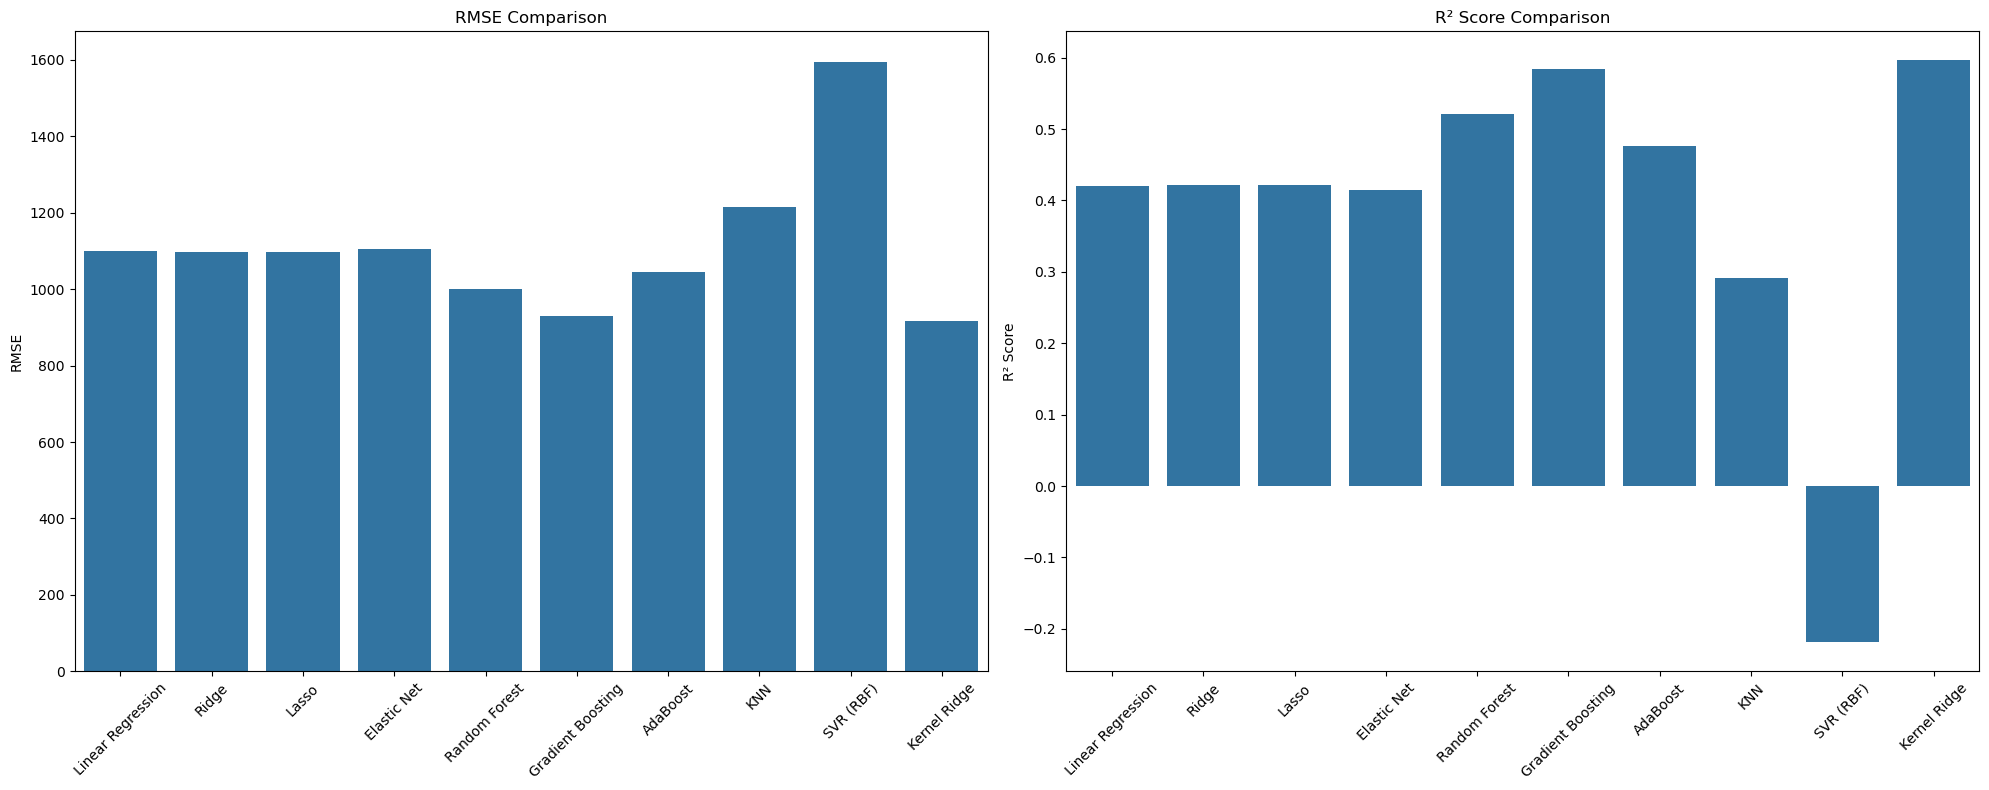

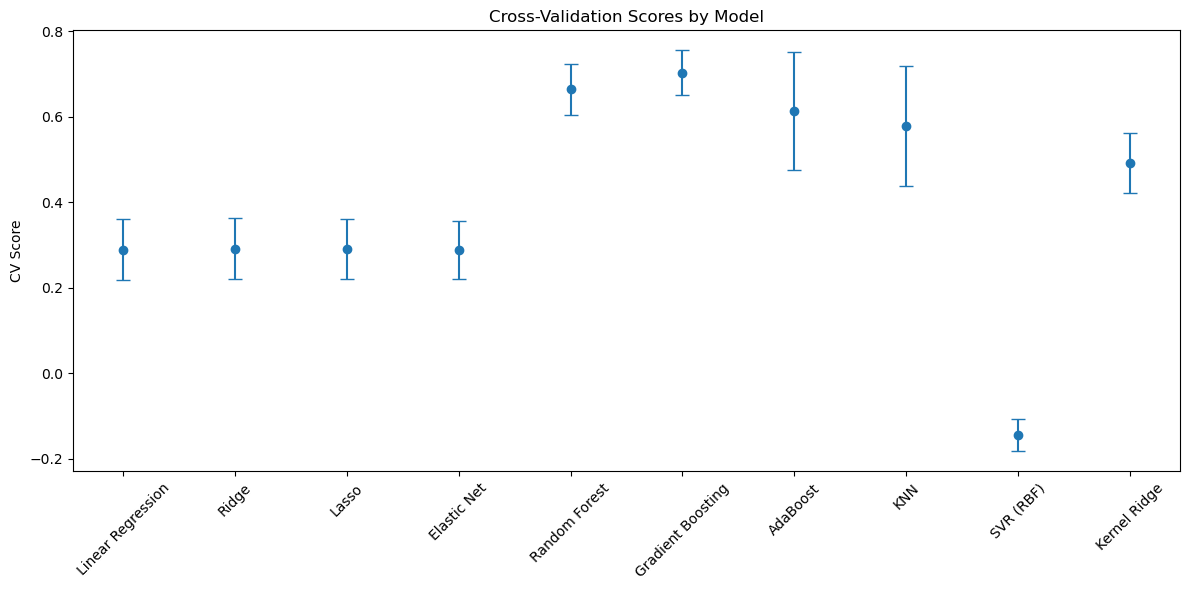

In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
# from statsmodels import KernelReg
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# [Previous data preparation functions remain the same]
def train_and_evaluate_expanded_models(X, y):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Initialize expanded set of models
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge': Ridge(alpha=1.0),
        'Lasso': Lasso(alpha=1.0),
        'Elastic Net': ElasticNet(alpha=1.0, l1_ratio=0.5),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
        'AdaBoost': AdaBoostRegressor(n_estimators=100, random_state=42),
        'KNN': KNeighborsRegressor(n_neighbors=5),
        'SVR (RBF)': SVR(kernel='rbf'),
        'Kernel Ridge': KernelRidge(kernel='rbf', alpha=1.0)
    }
    
    # Train and evaluate models
    results = {}
    trained_models = {}
    
    for name, model in models.items():
        try:
            # Train model
            model.fit(X_train_scaled, y_train)
            
            # Make predictions
            y_pred = model.predict(X_test_scaled)
            
            # Calculate metrics
            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)
            r2 = r2_score(y_test, y_pred)
            
            # Perform cross-validation
            cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
            
            results[name] = {
                'RMSE': rmse,
                'R2': r2,
                'CV_mean': cv_scores.mean(),
                'CV_std': cv_scores.std()
            }
            trained_models[name] = model
            
        except Exception as e:
            print(f"Error training {name}: {str(e)}")
    
    return results, trained_models, scaler

def plot_expanded_model_comparison(results):
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Prepare data for plotting
    models = list(results.keys())
    rmse_scores = [results[model]['RMSE'] for model in models]
    r2_scores = [results[model]['R2'] for model in models]
    
    # Plot RMSE comparison
    sns.barplot(x=models, y=rmse_scores, ax=ax1)
    ax1.set_title('RMSE Comparison')
    ax1.set_ylabel('RMSE')
    ax1.tick_params(axis='x', rotation=45)
    
    # Plot R² comparison
    sns.barplot(x=models, y=r2_scores, ax=ax2)
    ax2.set_title('R² Score Comparison')
    ax2.set_ylabel('R² Score')
    ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    return fig

def plot_cross_validation_results(results):
    fig, ax = plt.subplots(figsize=(12, 6))
    
    models = list(results.keys())
    cv_means = [results[model]['CV_mean'] for model in models]
    cv_stds = [results[model]['CV_std'] for model in models]
    
    # Plot CV scores with error bars
    ax.errorbar(models, cv_means, yerr=cv_stds, fmt='o', capsize=5)
    ax.set_title('Cross-Validation Scores by Model')
    ax.set_ylabel('CV Score')
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    return fig

# Main execution
if __name__ == "__main__":
    # Load and prepare data as before
    hist_df = pd.read_csv('../data/clean_data/data.csv')
    future_df = pd.read_csv('../data/clean_data/2050inputs.csv')
    
    X, y, imputer = prepare_training_data(hist_df)
    
    # Train and evaluate expanded set of models
    results, trained_models, scaler = train_and_evaluate_expanded_models(X, y)
    
    # Print detailed results
    print("\nModel Performance Metrics:")
    for model_name, metrics in results.items():
        print(f"\n{model_name}:")
        for metric_name, value in metrics.items():
            print(f"{metric_name}: {value:.4f}")
    
    # Plot comparisons
    comparison_fig = plot_expanded_model_comparison(results)
    cv_fig = plot_cross_validation_results(results)
    
    # Prepare and predict with 2050 data
    future_X = prepare_future_data(future_df, X.columns, imputer)
    future_X_scaled = scaler.transform(future_X)
    
    # Make predictions for 2050
    print("\nPredicted Lyme Disease Cases for 2050 by Region:")
    for model_name, model in trained_models.items():
        predictions = model.predict(future_X_scaled)
        print(f"\n{model_name} predictions:")
        for region, pred in zip(future_df['region'].unique(), predictions):
            print(f"{region}: {max(0, int(pred))} cases")
